Project:
*Nurse-stress-prediction-wearable-sensors*

Forecasting Stress Levels in Nurses by utilizing wearable
sensors

In [3]:
import os
import shutil
import multiprocessing


#load main zip & unzip in datasetfile

In [ ]:
MAIN_PATH = "C:\\Users\\raval\\Desktop\\stressdetection"

shutil.unpack_archive(MAIN_PATH + '\\Stress_dataset.zip', MAIN_PATH + '\\Data')
shutil.unpack_archive(MAIN_PATH + '\\Data\\Stress_dataset.zip', MAIN_PATH + '\\Data\\Stress_dataset')

stress_data_path = MAIN_PATH + '\\Data\\Stress_dataset'

cpu_count = int(multiprocessing.cpu_count()/2)
print(f'Using {cpu_count} CPUs')

new_list = [
    (file, sub_file) 
    for file in os.listdir(stress_data_path) 
    for sub_file in os.listdir(os.path.join(stress_data_path, file))
]

def unzip_parallel(file, sub_file):
    shutil.unpack_archive(
        os.path.join(stress_data_path, file, sub_file), 
        os.path.join(stress_data_path, file, sub_file[:-4])
    )

pool = multiprocessing.Pool(cpu_count)
results = pool.starmap(unzip_parallel, new_list)
pool.close()

#Combine all dataset


In [1]:
# Script to combine all signals into one
import os
import pandas as pd

DATA_PATH = "C:\\Users\\raval\\Desktop\\stressdetection\\Data"
SAVE_PATH = "C:\\Users\\raval\\Desktop\\stressdetection\\processed_data1"

os.mkdir(SAVE_PATH)

final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP'],
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']
desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']

acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])

def process_df(df, file):
    start_timestamp = df.iloc[0,0]
    sample_rate = df.iloc[1,0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] =  file[-2:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    return new_df

for file in os.listdir(DATA_PATH):
    print(f'Processing {file}')
    for sub_file in os.listdir(os.path.join(DATA_PATH, file)):
        if not sub_file.endswith(".zip"):
            for signal in os.listdir(os.path.join(DATA_PATH, file, sub_file)):
                if signal in desired_signals:
                    df = pd.read_csv(os.path.join(DATA_PATH, file, sub_file, signal), names=names[signal], header=None)
                    if not df.empty:
                        if signal == 'ACC.csv':
                            acc = pd.concat([acc, process_df(df, file)])             
                        if signal == 'EDA.csv':
                            eda = pd.concat([eda, process_df(df, file)])
                        if signal == 'HR.csv':
                            hr = pd.concat([hr, process_df(df, file)])
                        if signal == 'TEMP.csv':
                            temp = pd.concat([temp, process_df(df, file)])

print('Saving Data ...')
acc.to_csv(os.path.join(SAVE_PATH, 'combined_acc.csv'), index=False)
eda.to_csv(os.path.join(SAVE_PATH, 'combined_eda.csv'), index=False)
hr.to_csv(os.path.join(SAVE_PATH, 'combined_hr.csv'), index=False)
temp.to_csv(os.path.join(SAVE_PATH, 'combined_temp.csv'), index=False)

Processing 15
Processing 5C
Processing 6B
Processing 6D
Processing 7A
Processing 7E
Processing 83
Processing 8B
Processing 94
Processing BG
Processing CE
Processing DF
Processing E4
Processing EG
Processing F5
Saving Data ...


#Merge All Data

In [ ]:
import pandas as pd
import os
import multiprocessing

COMBINED_DATA_PATH = "C:\\Users\\raval\\Desktop\\stressdetection\\processed_data2"
SAVE_PATH = "C:\\Users\\raval\\Desktop\\stressdetection\\merge"

if COMBINED_DATA_PATH != SAVE_PATH:
    os.mkdir(SAVE_PATH)

print("Reading data ...")

acc, eda, hr, temp = None, None, None, None

signals = ['acc', 'eda', 'hr', 'temp']

def read_parallel(signal):
    df = pd.read_csv(os.path.join(COMBINED_DATA_PATH, f"combined_{signal}.csv"), dtype={'id': str})
    return [signal, df]

pool = multiprocessing.Pool(len(signals))
results = pool.map(read_parallel, signals)
pool.close()
pool.join()

for i in results:
    globals()[i[0]] = i[1]

# Merge data
print('Merging Data ...')
ids = eda['id'].unique()
columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime']

def merge_parallel(id):
    print(f"Processing {id}")
    df = pd.DataFrame(columns=columns)
    
    acc_id = acc[acc['id'] == id]
    eda_id = eda[eda['id'] == id].drop(['id'], axis=1)
    hr_id = hr[hr['id'] == id].drop(['id'], axis=1)
    temp_id = temp[temp['id'] == id].drop(['id'], axis=1)

    df = acc_id.merge(eda_id, on='datetime', how='outer')
    df = df.merge(temp_id, on='datetime', how='outer')
    df = df.merge(hr_id, on='datetime', how='outer')

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

pool = multiprocessing.Pool(len(ids))
results = pool.map(merge_parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print("Saving data ...")
new_df.to_csv(os.path.join(SAVE_PATH, "merged_data.csv"), index=False)

Reading data ...


#compare each nurse csv with survey result file for the final result

In [ ]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import os
import multiprocessing

print("Reading 1 ...")
PATH = "C:\\Users\\raval\\Desktop\\stressdetection\\merge1\\merged files"

df = pd.read_csv(os.path.join(PATH, 'merged_data_5C.csv'), dtype={'id': str})
df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x * (10 ** 9)))

print("Reading 2 ...")
survey_path = "C:\\Users\\raval\\Desktop\\stressdetection\\SurveyResults.xlsx"

survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)
survey_df.replace({'missing_value': 'NaN'}, inplace=True)

survey_df['Start datetime'] = pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['Start time'].map(str))
survey_df['End datetime'] = pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['End time'].map(str))
survey_df.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

print("Converting ...")
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey_df1 = survey_df[survey_df['End datetime'] <= daylight].copy()
survey_df1['Start datetime'] = survey_df1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_df1['End datetime'] = survey_df1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_df2 = survey_df.loc[survey_df['End datetime'] > daylight].copy()
survey_df2['Start datetime'] = survey_df2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_df2['End datetime'] = survey_df2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_df = pd.concat([survey_df1, survey_df2], ignore_index=True)

survey_df = survey_df.loc[survey_df['Stress level'] != 1.0]
survey_df.reset_index(drop=True, inplace=True)

print('Labelling ...')

if 'id' in df.columns:
    ids = df['id'].unique()
else:
    raise KeyError("'id' column not found in DataFrame 'df'.")

def parallel(id):
    new_df = pd.DataFrame(columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'])

    sdf = df[df['id'] == id].copy()
    survey_sdf = survey_df[survey_df['ID'] == id].copy()

    for _, survey_row in survey_sdf.iterrows():
        ssdf = sdf[(sdf['datetime'] >= survey_row['Start datetime']) & (sdf['datetime'] <= survey_row['End datetime'])].copy()

        if not ssdf.empty:
            ssdf['label'] = np.repeat(survey_row['Stress level'], len(ssdf.index))
            new_df = pd.concat([new_df, ssdf], ignore_index=True)
        else:
            print(f"{survey_row['ID']} is missing label {survey_row['Stress level']} at {survey_row['Start datetime']} to {survey_row['End datetime']}")
        
    return new_df

if __name__ == '__main__':
    multiprocessing.freeze_support()

    pool = multiprocessing.Pool(len(ids))
    results = pool.map(parallel, ids)
    pool.close()
    pool.join()

    new_df = pd.concat(results, ignore_index=True)

    print('Saving ...')
    new_df.to_csv(os.path.join(PATH, 'new_merged_file_5c.csv'), index=False)
    print('Done')

Reading 1 ...
Reading 2 ...
Converting ...
Labelling ...


#clean survey result file

In [110]:
import pandas as pd

survey_path = "C:\\Users\\raval\\Desktop\\stressdetection\\SurveyResults.xlsx"

# read survey results file and drop NaN values
survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)

# save updated dataframe to a new file
survey_df.to_csv("C:\\Users\\raval\\Desktop\\stressdetection\\survey_results_cleaned.csv", index=False)
clean_df = pd.read_csv("C:\\Users\\raval\\Desktop\\stressdetection\\survey_results_cleaned.csv")
clean_df

# Group the data by ID and get the row with the maximum temperature for each group
max_stres_rows = clean_df.loc[clean_df.groupby("ID")["Stress level"].idxmax()]

# Print the details of the row with the maximum temperature for each group
print(max_stres_rows)

     ID Start time  End time        date  Stress level
123  15   09:03:00  09:14:00  2020-07-08           2.0
43   5C   08:56:00  10:12:00  2020-06-24           2.0
36   6B   11:25:00  11:49:00  2020-06-23           2.0
141  6D   09:49:00  10:24:00  2020-07-16           2.0
4    7A   13:52:00  14:03:00  2020-04-18           2.0
206  7E   10:09:00  10:27:00  2020-10-31           2.0
196  83   03:20:00  03:52:00  2020-10-28           2.0
127  8B   11:59:00  12:05:00  2020-07-13           2.0
23   94   18:55:00  19:03:00  2020-05-10           2.0
198  BG   19:30:00  19:55:00  2020-10-28           2.0
27   CE   09:55:00  10:08:00  2020-05-09           2.0
159  DF   09:01:00  09:05:00  2020-07-21           2.0
2    E4   15:32:00  15:37:00  2020-04-18           2.0
221  EG   09:50:00  10:33:00  2020-11-08           2.0
126  F5   10:56:00  11:02:00  2020-07-08           2.0


#load all final labeled data in one csv

In [5]:
import pandas as pd

path = "C:\\Users\\raval\\Desktop\\stressdetection\\merge1\\Labeled Data"

# Get a list of all the CSV files in the directory
file_list = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]

# Load each CSV file into a separate DataFrame and store in a list
df_list = [pd.read_csv(f) for f in file_list]

# Concatenate the list of DataFrames into a single DataFrame
merged_df = pd.concat(df_list, ignore_index=True)
merged_df


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [10]:
# Save the merged DataFrame as a single CSV file
merged_df.to_csv("merged_data.csv", index=False)

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   EDA       float64
 4   HR        float64
 5   TEMP      float64
 6   id        object 
 7   datetime  object 
 8   label     float64
dtypes: float64(7), object(2)
memory usage: 790.3+ MB


In [28]:
merged_df.nunique()

X                256
Y                256
Z                256
EDA           274452
HR              6268
TEMP             599
id                15
datetime    10628304
label              3
dtype: int64

In [2]:
# Group the data by ID and get the row with the maximum temperature for each group
max_temp_rows = merged_df.loc[merged_df.groupby("id")["TEMP"].idxmax()]

# Print the details of the row with the maximum temperature for each group
print(max_temp_rows)

             X     Y      Z        EDA      HR   TEMP  id  \
144005   -57.0   4.0  -15.0   3.075611   77.07  35.50  15   
4574030  -64.0   7.0    4.0   1.662621   83.83  36.23  83   
6057489  -66.0 -31.0  -29.0  18.849356   79.98  36.57  94   
317291   -22.0 -44.0  127.0  20.073507   85.88  36.59  5C   
1869983  -47.0  25.0   40.0   1.948249   78.42  32.71  6B   
2000610  -27.0   4.0   58.0   0.515300  108.03  34.25  6D   
3206510  -53.0 -23.0  -12.0   3.388557   93.53  36.13  7A   
4096807   -7.0  35.0   52.0   0.961276   81.85  35.87  7E   
5668159  -64.0 -16.0  -18.0   1.838395  101.73  35.91  8B   
7067948  -41.0 -35.0  -86.0  11.188519   75.22  36.43  BG   
7358546   -1.0  32.0   36.0   0.102488   77.55  31.53  CE   
8516540  -50.0   5.0   42.0   0.655017   73.98  32.21  DF   
9033252   -5.0  56.0   22.0   1.686827   88.92  35.75  E4   
10446845  61.0   1.0   20.0   0.519143   88.50  34.37  EG   
11259857 -28.0  12.0   57.0   4.845623   82.63  35.50  F5   

                       

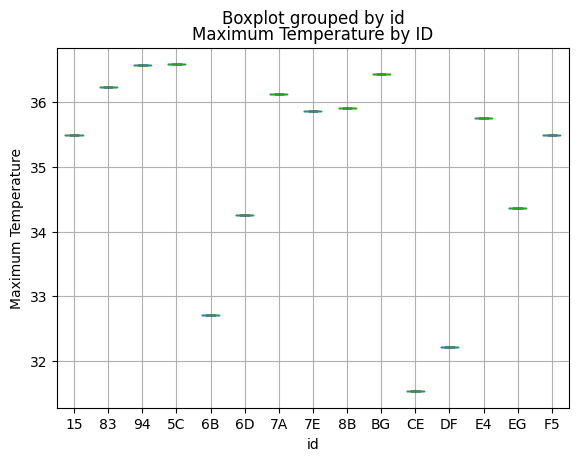

In [3]:
# Group the data by ID and calculate the maximum temperature for each group
max_temps = merged_df.groupby("id")["TEMP"].max()

# Convert the maximum temperature data to a pandas DataFrame
max_temps_merged_df = pd.DataFrame(max_temps)

# Create a boxplot with the maximum temperature data, with the ID on the x-axis
max_temps_merged_df.boxplot(column="TEMP", by="id")

# Set the axis labels and title
plt.xlabel("id")
plt.ylabel("Maximum Temperature")
plt.title("Maximum Temperature by ID")

# Display the plot
plt.show()

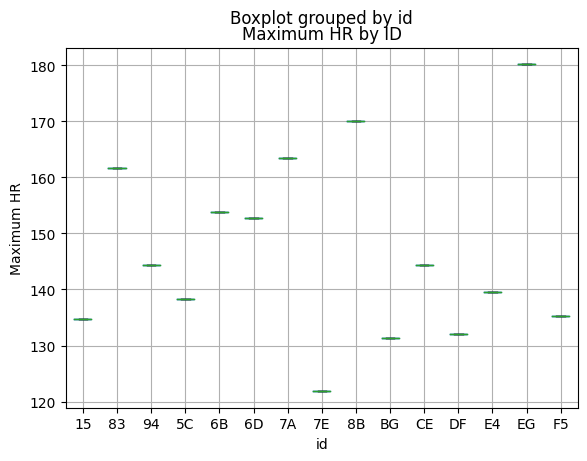

In [4]:
# Group the data by ID and calculate the maximum hr for each group
max_hr = merged_df.groupby("id")["HR"].max()

# Convert the maximum edas data to a pandas DataFrame
max_hr_merged_df = pd.DataFrame(max_hr)

# Create a boxplot with the maximum hr data, with the ID on the x-axis
max_hr_merged_df.boxplot(column="HR", by="id")

# Set the axis labels and title
plt.xlabel("id")
plt.ylabel("Maximum HR")
plt.title("Maximum HR by ID")

# Display the plot
plt.show()

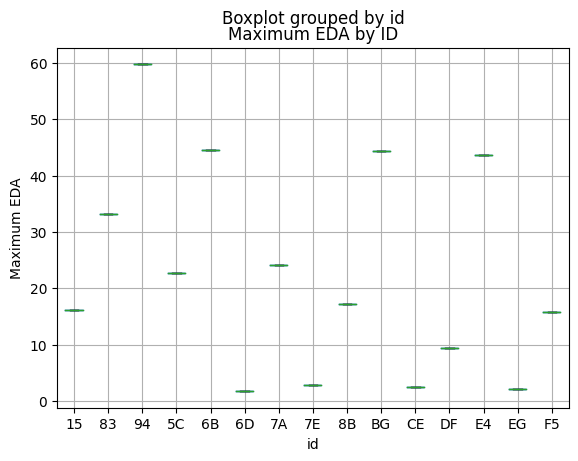

In [5]:
# Group the data by ID and calculate the maximum eda for each group
max_eda = merged_df.groupby("id")["EDA"].max()

# Convert the maximum edas data to a pandas DataFrame
max_eda_merged_df = pd.DataFrame(max_eda)

# Create a boxplot with the maximum eda data, with the ID on the x-axis
max_eda_merged_df.boxplot(column="EDA", by="id")

# Set the axis labels and title
plt.xlabel("id")
plt.ylabel("Maximum EDA")
plt.title("Maximum EDA by ID")

# Display the plot
plt.show()

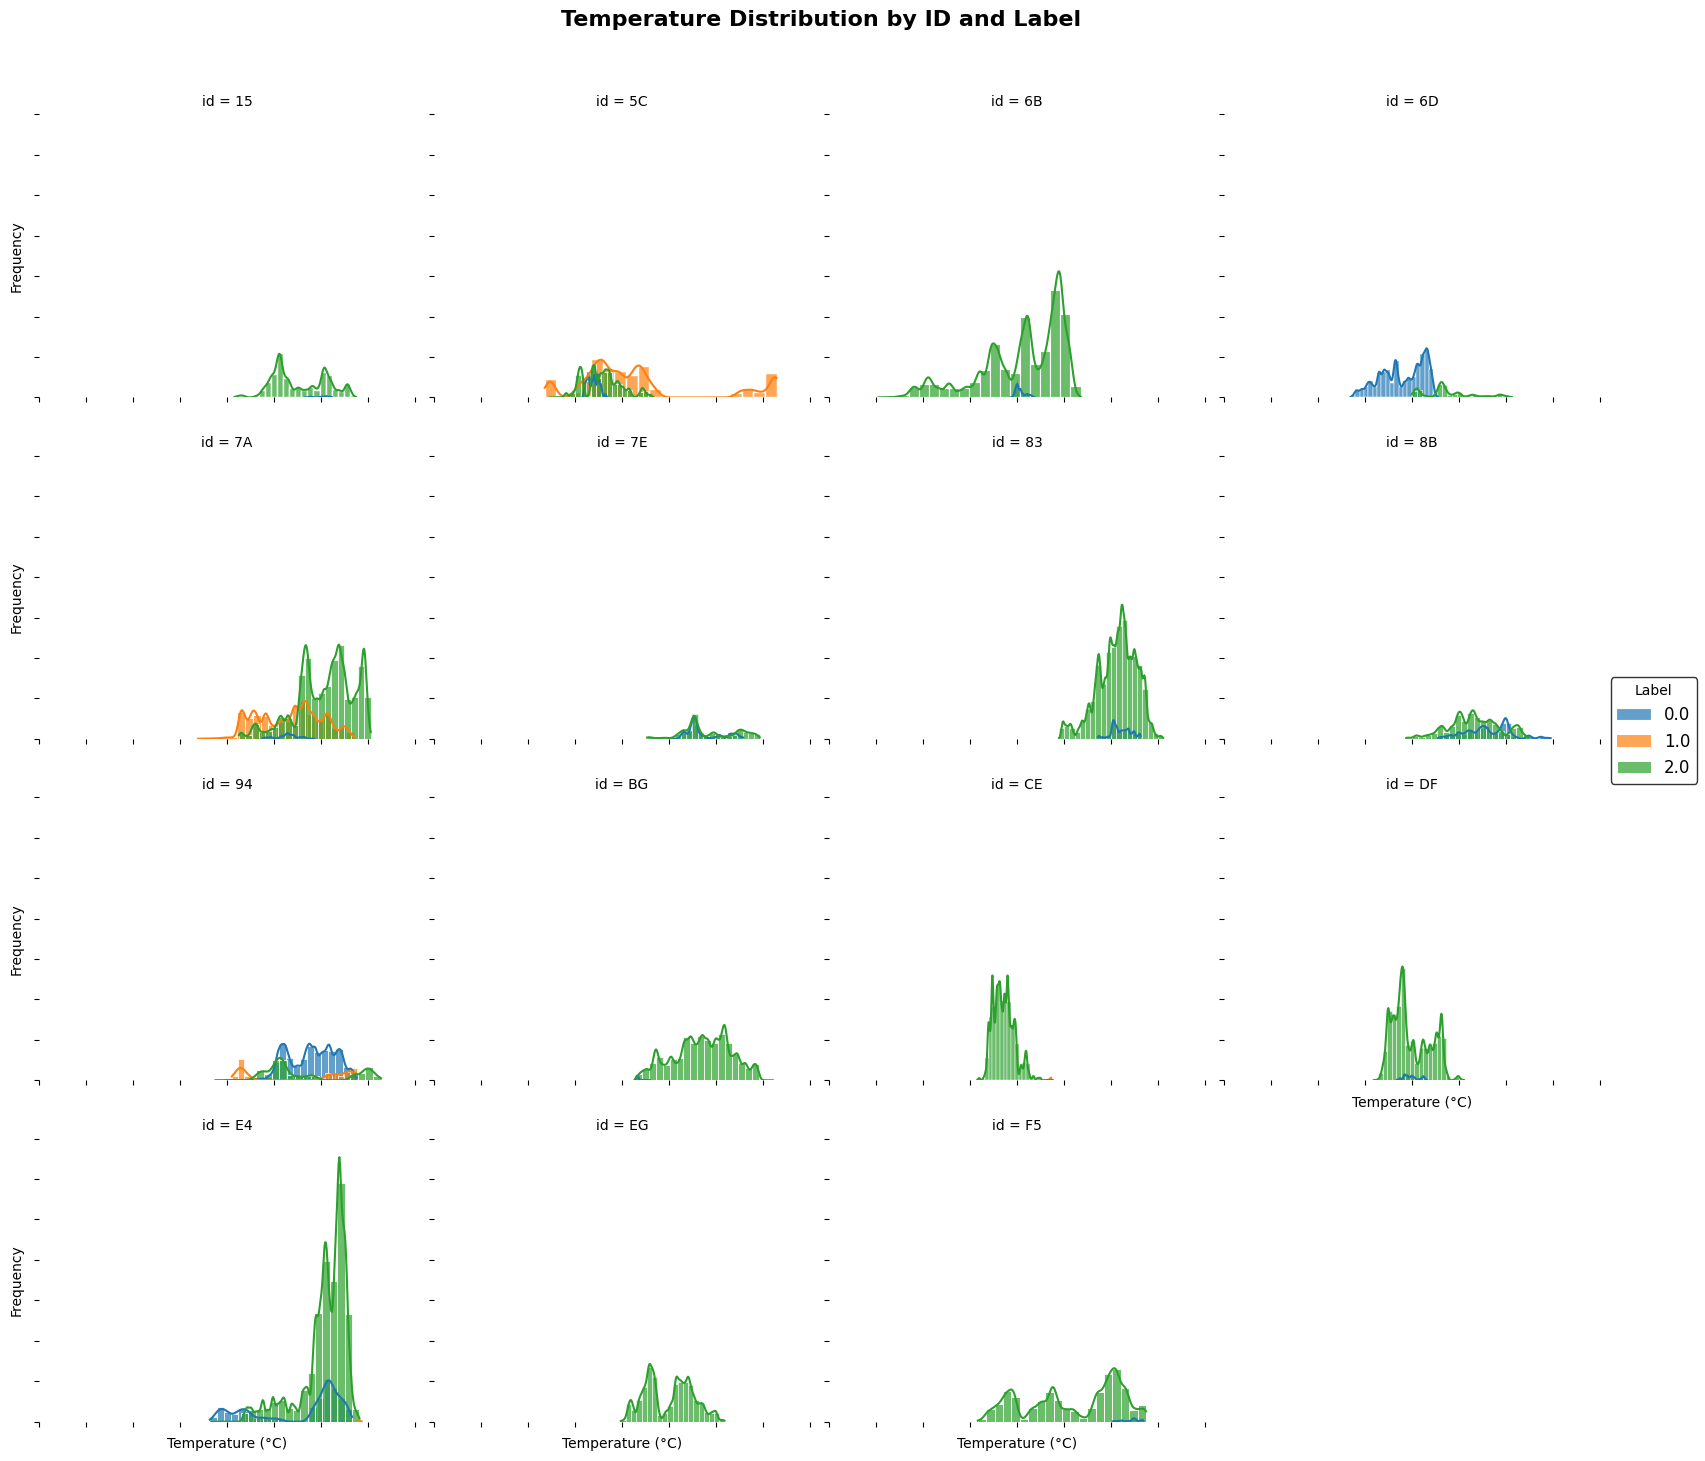

In [ ]:
import seaborn as sns

# Create a FacetGrid with one plot for each combination of ID and label
g = sns.FacetGrid(merged_df, col="id", hue="label", col_wrap=4, height=3.5, aspect=1.2)

# Map a histogram of the temperature data to each plot
g.map(sns.histplot, "TEMP", bins=20, kde=True, alpha=0.7, edgecolor='white')

# Set the axis labels and title
g.set_axis_labels("Temperature (°C)", "Frequency")
g.fig.suptitle("Temperature Distribution by ID and Label", y=1.05, fontsize=16, fontweight='bold')

# Add legend
g.add_legend(fontsize=12, title="Label", title_fontsize=14, frameon=True, edgecolor='black')

# Customize ticks and spines
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)

# Display the plot
plt.show()


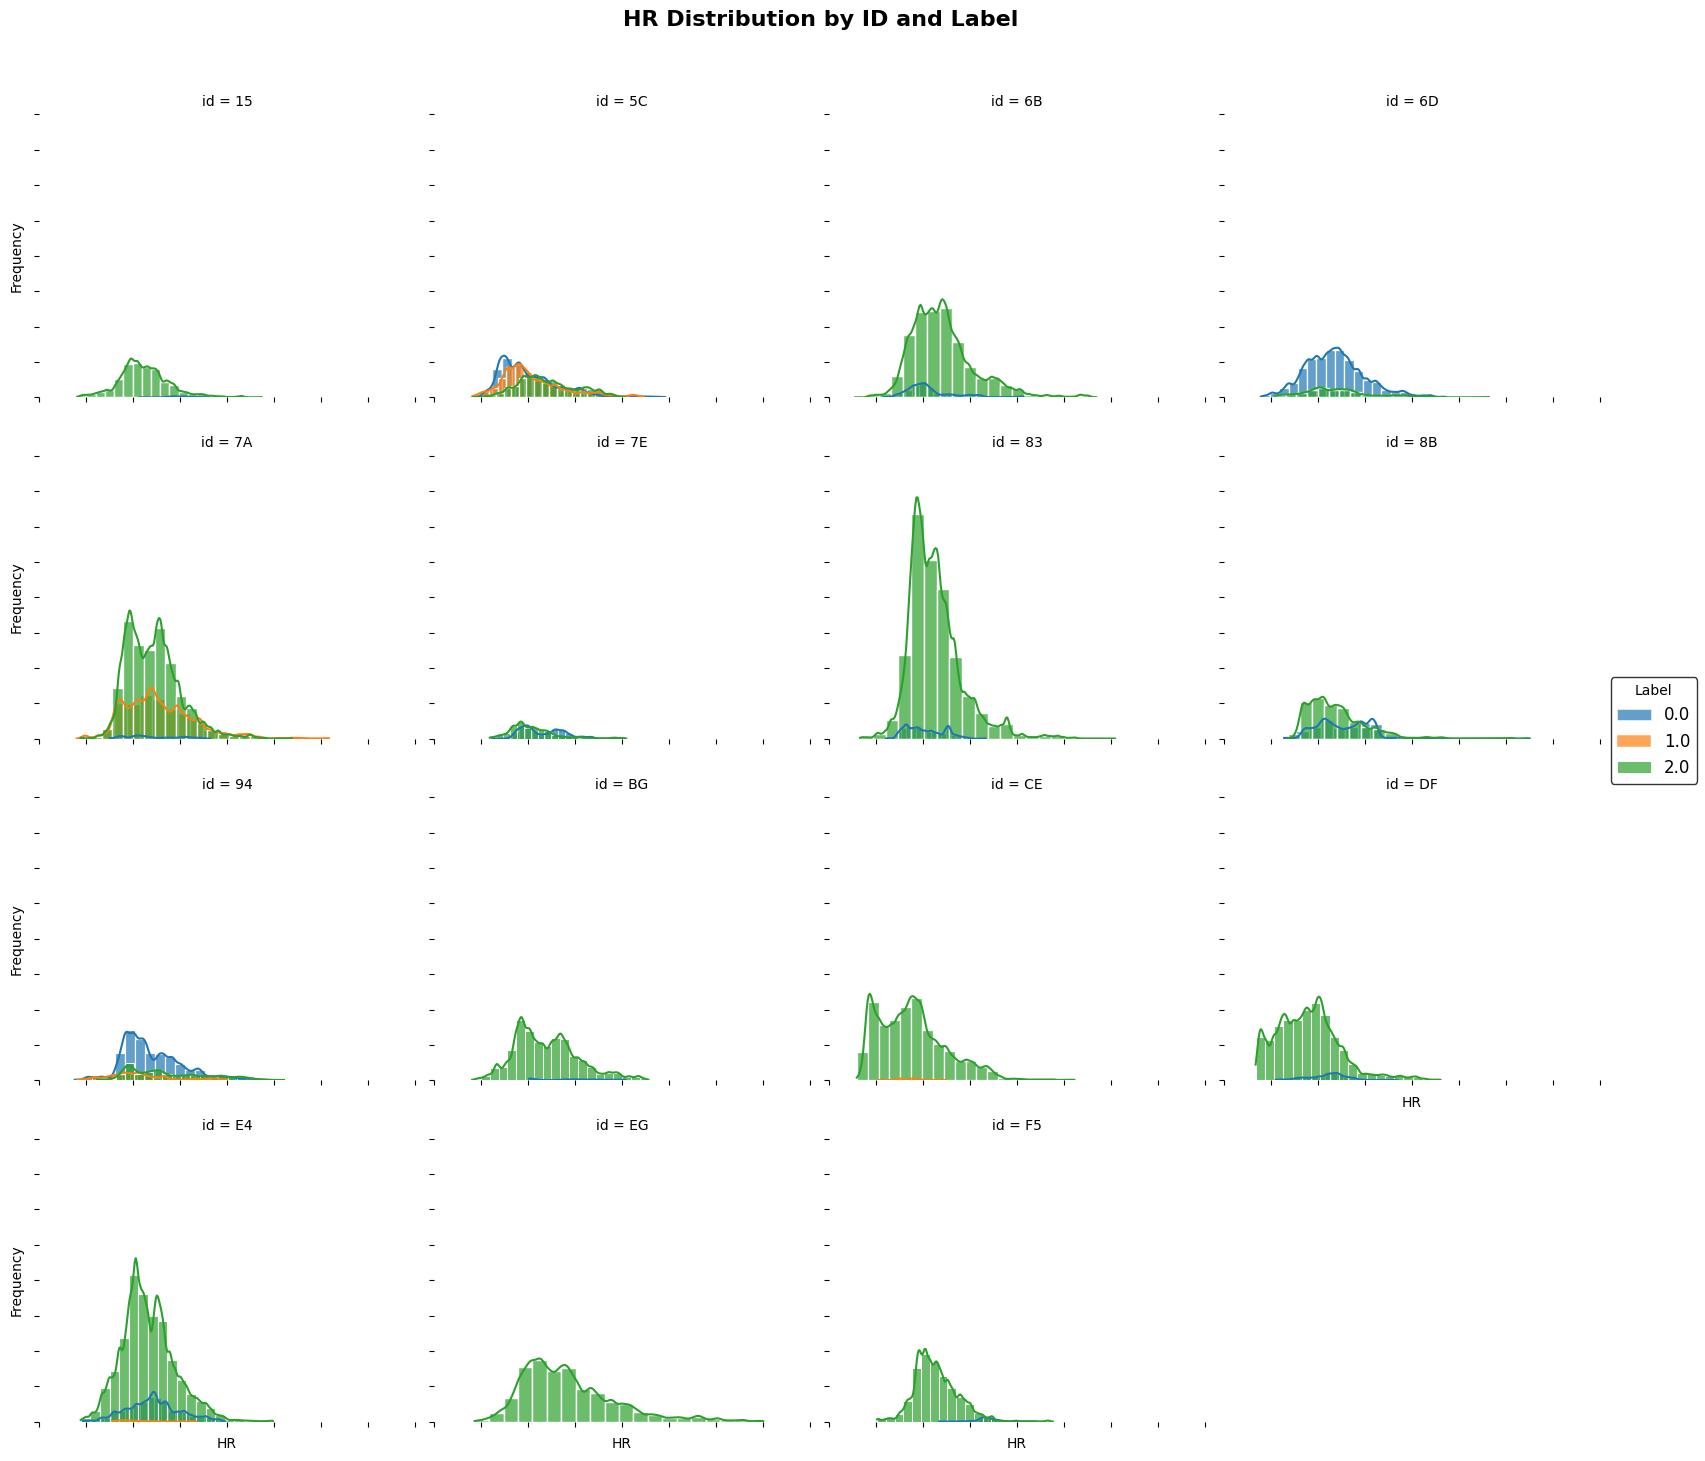

In [3]:
import seaborn as sns

# Create a FacetGrid with one plot for each combination of ID and label
g = sns.FacetGrid(merged_df, col="id", hue="label", col_wrap=4, height=3.5, aspect=1.2)

# Map a histogram of the hr data to each plot
g.map(sns.histplot, "HR", bins=20, kde=True, alpha=0.7, edgecolor='white')

# Set the axis labels and title
g.set_axis_labels("HR", "Frequency")
g.fig.suptitle("HR Distribution by ID and Label", y=1.05, fontsize=16, fontweight='bold')

# Add legend
g.add_legend(fontsize=12, title="Label", title_fontsize=14, frameon=True, edgecolor='black')

# Customize ticks and spines
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)

# Display the plot
plt.show()


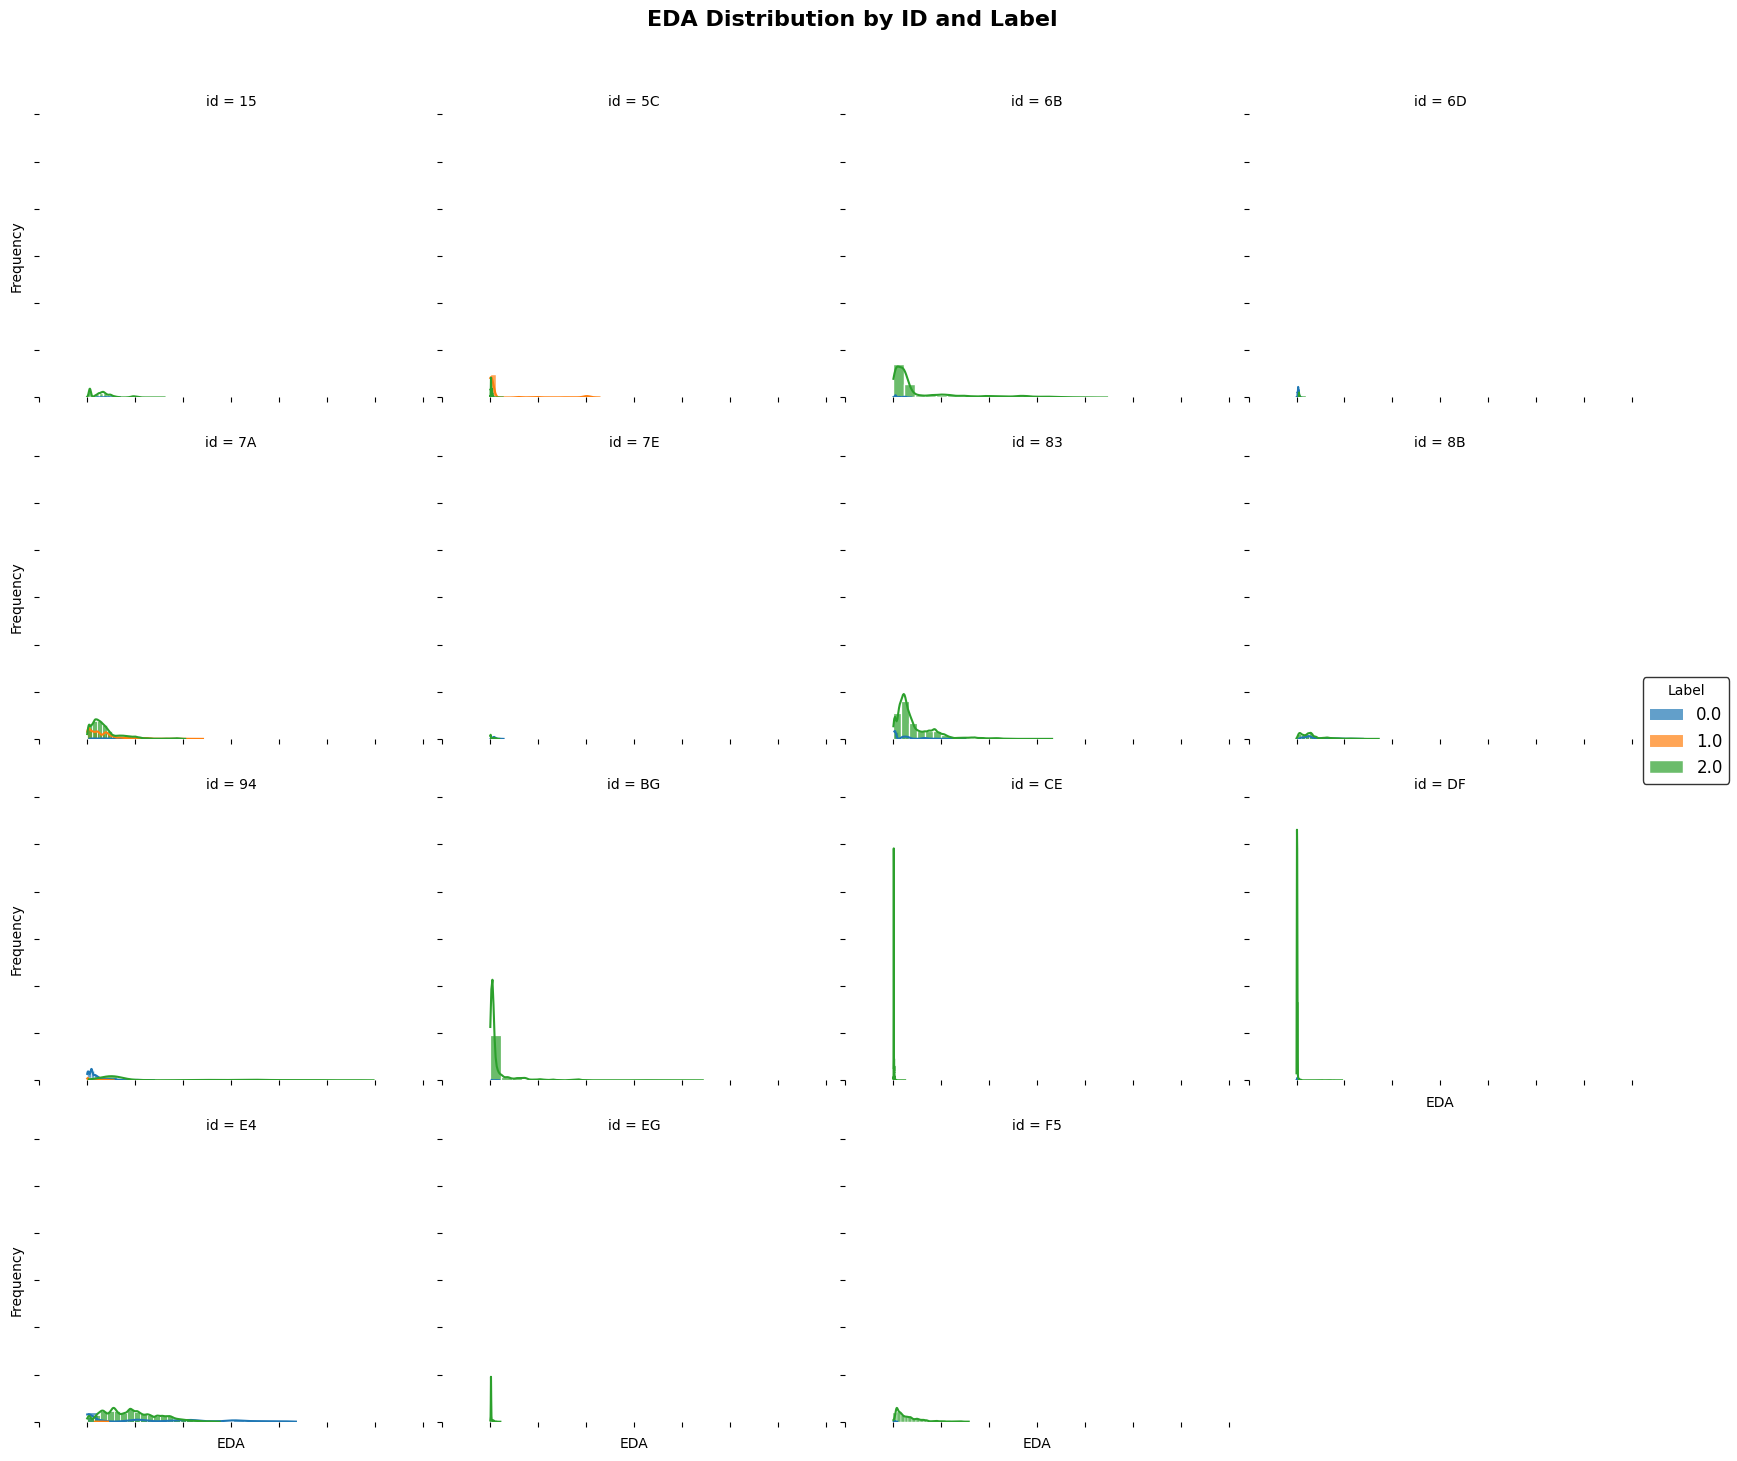

In [30]:
import seaborn as sns

# Create a FacetGrid with one plot for each combination of ID and label
g = sns.FacetGrid(merged_df, col="id", hue="label", col_wrap=4, height=3.5, aspect=1.2)

# Map a histogram of the EDA data to each plot
g.map(sns.histplot, "EDA", bins=20, kde=True, alpha=0.7, edgecolor='white')

# Set the axis labels and title
g.set_axis_labels("EDA", "Frequency")
g.fig.suptitle("EDA Distribution by ID and Label", y=1.05, fontsize=16, fontweight='bold')

# Add legend
g.add_legend(fontsize=12, title="Label", title_fontsize=14, frameon=True, edgecolor='black')

# Customize ticks and spines
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)

# Display the plot
plt.show()


In [11]:
import pandas as pd

# group by ID and calculate maximum temperature, HR, EDA, and stress level for each ID
temp_summary = merged_df.groupby("id")["TEMP"].max().describe()
hr_summary = merged_df.groupby("id")["HR"].max().describe()
eda_summary = merged_df.groupby("id")["EDA"].max().describe()
stress_summary = merged_df.groupby("id")["label"].max().describe()

# concatenate the data frames horizontally
summary_table = pd.concat([temp_summary, hr_summary, eda_summary, stress_summary], axis=1)

# rename the columns
summary_table.columns = ["Max Temp", "Max HR", "Max EDA", "Max Stress"]

# print the summary table
print("Summary statistics for each variable by ID:\n")
print(summary_table)


Summary statistics for each variable by ID:

        Max Temp      Max HR    Max EDA  Max Stress
count  15.000000   15.000000  15.000000        15.0
mean   35.036667  146.939333  22.656261         2.0
std     1.657958   16.346317  18.585328         0.0
min    31.530000  121.820000   1.723618         2.0
25%    34.310000  135.040000   6.132917         2.0
50%    35.750000  144.330000  17.153090         2.0
75%    36.180000  157.760000  38.339461         2.0
max    36.590000  180.230000  59.760712         2.0


In [29]:
import pandas as pd

# group by ID and calculate maximum temperature, HR, EDA, and stress level for each ID
max_temp = merged_df.groupby("id")["TEMP"].max().rename("Max Temp")
max_hr = merged_df.groupby("id")["HR"].max().rename("Max HR")
max_eda = merged_df.groupby("id")["EDA"].max().rename("Max EDA")
max_stress = merged_df.groupby("id")["label"].max().rename("Max Stress")

# concatenate the data frames horizontally
summary_table = pd.concat([max_temp, max_hr, max_eda, max_stress], axis=1)

# print the summary table for all IDs
print(summary_table)


    Max Temp  Max HR    Max EDA  Max Stress
id                                         
15     35.50  134.80  16.137552         2.0
83     36.23  161.77  33.115532         2.0
94     36.57  144.33  59.760712         2.0
5C     36.59  138.37  22.777302         2.0
6B     32.71  153.75  44.583832         2.0
6D     34.25  152.75   1.723618         2.0
7A     36.13  163.50  24.167313         2.0
7E     35.87  121.82   2.766914         2.0
8B     35.91  170.12  17.153090         2.0
BG     36.43  131.27  44.341255         2.0
CE     31.53  144.43   2.439848         2.0
DF     32.21  132.10   9.498919         2.0
E4     35.75  139.57  43.563389         2.0
EG     34.37  180.23   2.096440         2.0
F5     35.50  135.28  15.718194         2.0


#Scatter Plot

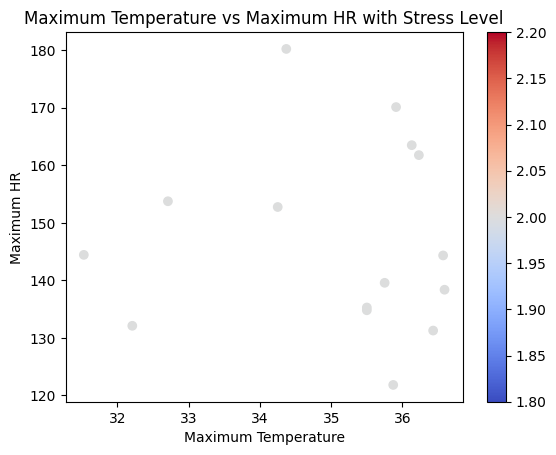

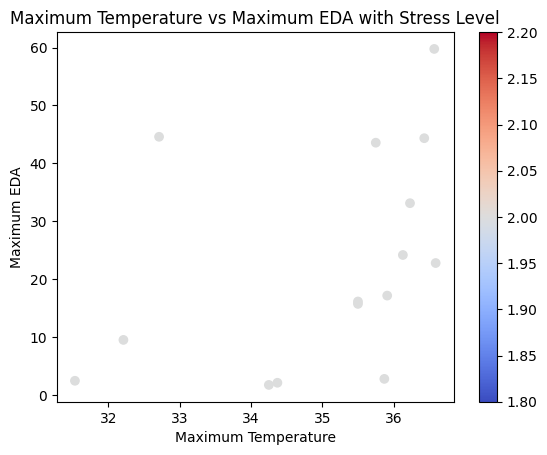

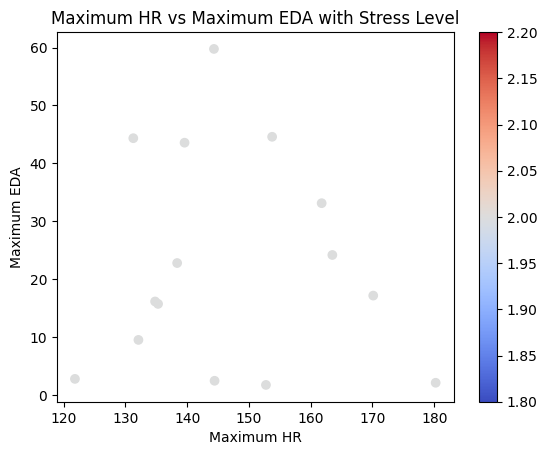

In [ ]:
import matplotlib.pyplot as plt

# Get the maximum values of temperature, HR, and EDA for each individual
max_temp_rows = merged_df.loc[merged_df.groupby("id")["TEMP"].idxmax()]
max_hr = merged_df.groupby("id")["HR"].max()
max_eda = merged_df.groupby("id")["EDA"].max()

# Create scatter plots for the relationships between maximum temperature, maximum HR, and maximum EDA with the stress level as the color
plt.scatter(max_temp_rows["TEMP"], max_hr, c=merged_df.groupby("id")["label"].max(), cmap="coolwarm")
plt.xlabel("Maximum Temperature")
plt.ylabel("Maximum HR")
plt.title("Maximum Temperature vs Maximum HR with Stress Level")
plt.colorbar()
plt.show()

plt.scatter(max_temp_rows["TEMP"], max_eda, c=merged_df.groupby("id")["label"].max(), cmap="coolwarm")
plt.xlabel("Maximum Temperature")
plt.ylabel("Maximum EDA")
plt.title("Maximum Temperature vs Maximum EDA with Stress Level")
plt.colorbar()
plt.show()

plt.scatter(max_hr, max_eda, c=merged_df.groupby("id")["label"].max(), cmap="coolwarm")
plt.xlabel("Maximum HR")
plt.ylabel("Maximum EDA")
plt.title("Maximum HR vs Maximum EDA with Stress Level")
plt.colorbar()
plt.show()


C:\Users\raval\AppData\Local\Temp\ipykernel_6480\3795993224.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data = merged_df.groupby("id").mean()


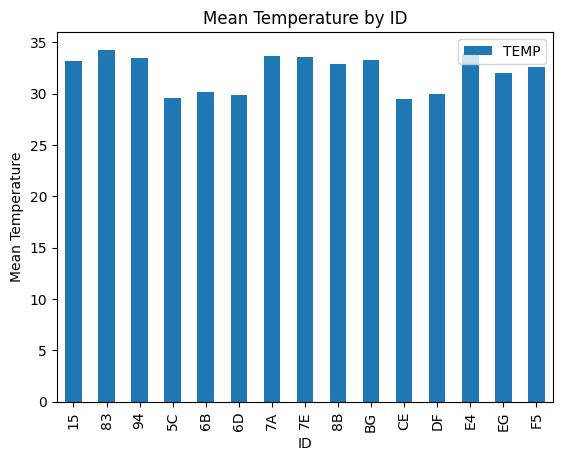

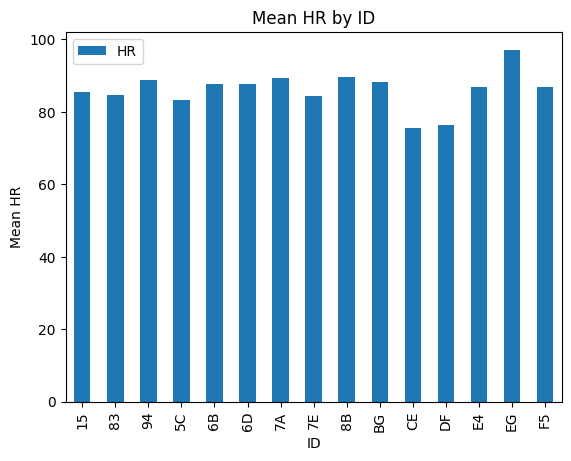

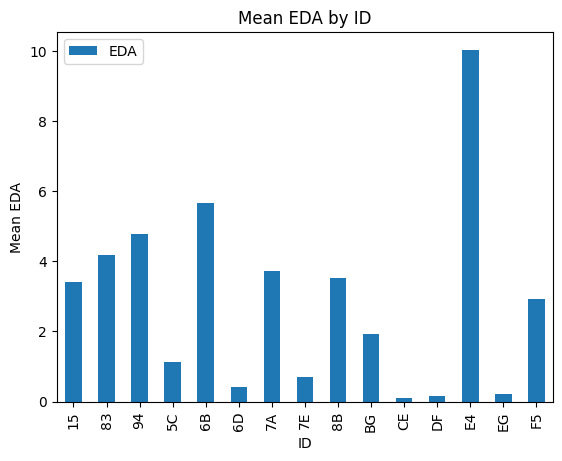

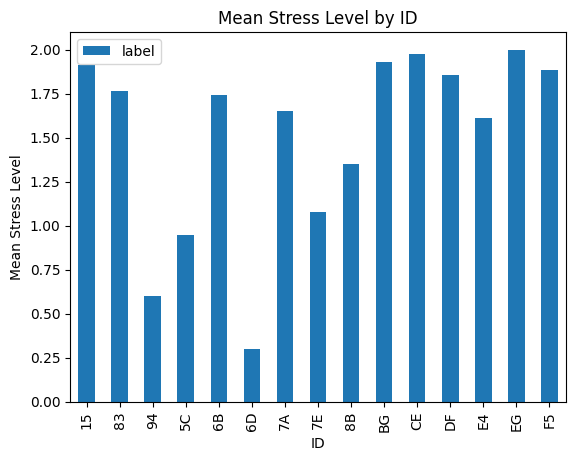

In [18]:
# Group the data by ID and calculate the mean for each variable
mean_data = merged_df.groupby("id").mean()

# Create a bar plot for each variable, with the ID on the x-axis
mean_data.plot(kind="bar", y="TEMP", xlabel="ID", ylabel="Mean Temperature", title="Mean Temperature by ID")
mean_data.plot(kind="bar", y="HR", xlabel="ID", ylabel="Mean HR", title="Mean HR by ID")
mean_data.plot(kind="bar", y="EDA", xlabel="ID", ylabel="Mean EDA", title="Mean EDA by ID")
mean_data.plot(kind="bar", y="label", xlabel="ID", ylabel="Mean Stress Level", title="Mean Stress Level by ID")

# Display the plots
plt.show()


In [32]:
# Calculate the average value of each variable for each ID
avg_df = merged_df.groupby("id").mean()
print (avg_df)

            X          Y          Z        EDA         HR       TEMP     label
id                                                                            
15 -36.356933   6.403709  25.034917   3.421331  85.465350  33.147760  1.913040
83 -40.618391 -13.977849  18.405102   4.190696  84.679040  34.280845  1.762235
94 -38.483755  -3.367235  16.253841   4.765124  88.894057  33.463010  0.601314
5C -32.438792   1.790679  33.242173   1.142849  83.321125  29.522039  0.944572
6B -42.230072 -13.812744  16.228565   5.648842  87.669390  30.188753  1.739514
6D -22.563798   5.281994  33.187185   0.405037  87.589061  29.880214  0.298707
7A -33.997192  -2.323310  16.884319   3.721162  89.328539  33.701364  1.651008
7E -43.660888  -1.473622  21.602453   0.703893  84.263429  33.603122  1.075752
8B -30.172264   7.503034  14.926992   3.516680  89.567725  32.839419  1.347546
BG -32.770001  -4.102270  31.584676   1.927448  88.212847  33.314649  1.930595
CE -39.566017   1.617167  25.937518   0.096781  75.4

C:\Users\raval\AppData\Local\Temp\ipykernel_11120\4050116330.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_df = merged_df.groupby("id").mean()


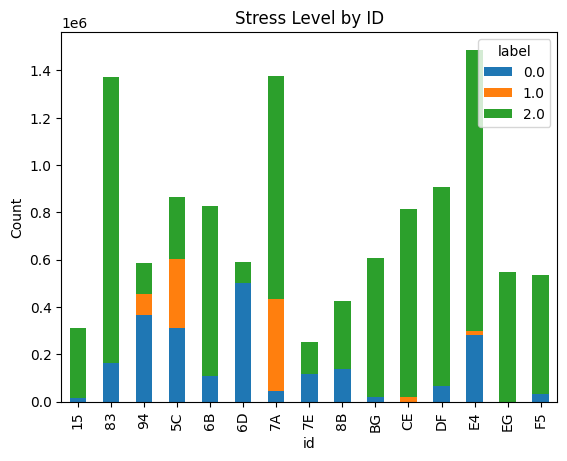

In [20]:
# Count the number of occurrences of each label for each ID
label_counts = merged_df.groupby(['id', 'label']).size().unstack()

# Create a stacked bar chart
label_counts.plot(kind='bar', stacked=True)

# Set the axis labels and title
plt.xlabel('id')
plt.ylabel('Count')
plt.title('Stress Level by ID')

# Display the plot
plt.show()


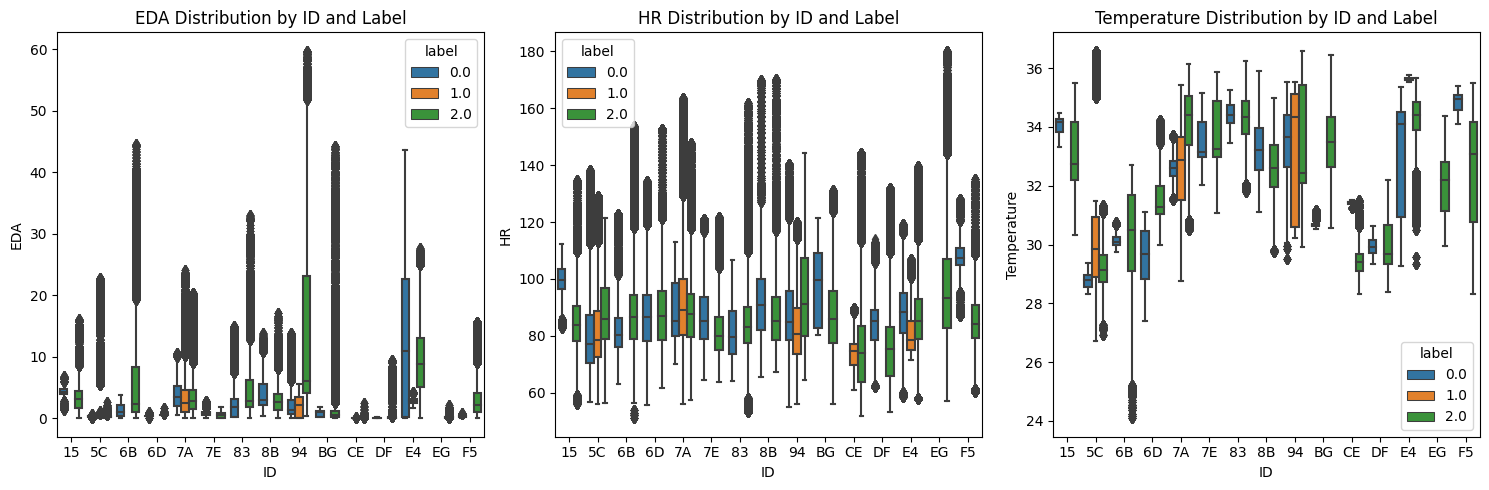

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Create a box plot of temperature for each ID, colored by label
sns.boxplot(x="id", y="EDA", hue="label", data=merged_df, ax=axs[0])
sns.boxplot(x="id", y="HR", hue="label", data=merged_df, ax=axs[1])
sns.boxplot(x="id", y="TEMP", hue="label", data=merged_df, ax=axs[2])

# Set the axis labels and title for each subplot
axs[0].set_xlabel("ID")
axs[0].set_ylabel("EDA")
axs[0].set_title("EDA Distribution by ID and Label")

axs[1].set_xlabel("ID")
axs[1].set_ylabel("HR")
axs[1].set_title("HR Distribution by ID and Label")

axs[2].set_xlabel("ID")
axs[2].set_ylabel("Temperature")
axs[2].set_title("Temperature Distribution by ID and Label")

# Adjust the layout of the subplots to avoid overlapping
plt.tight_layout()

# Display the plot
plt.show()


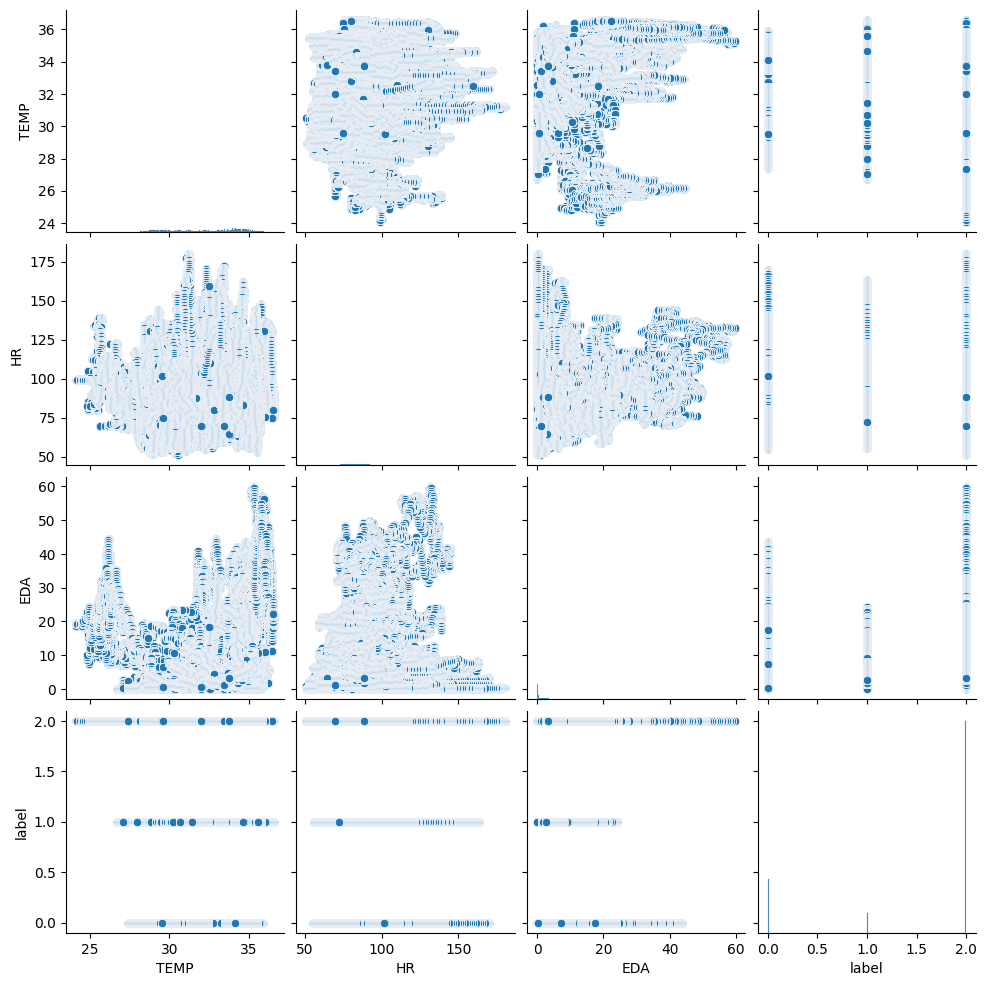

In [21]:
# Select the columns of interest
cols_of_interest = ["TEMP", "HR", "EDA", "label"]

# Create a pairplot with the selected columns
sns.pairplot(data=merged_df[cols_of_interest])

C:\Users\raval\AppData\Local\Temp\ipykernel_11120\2176096628.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_df[["id", "label", "TEMP", "HR", "EDA"]].corr()


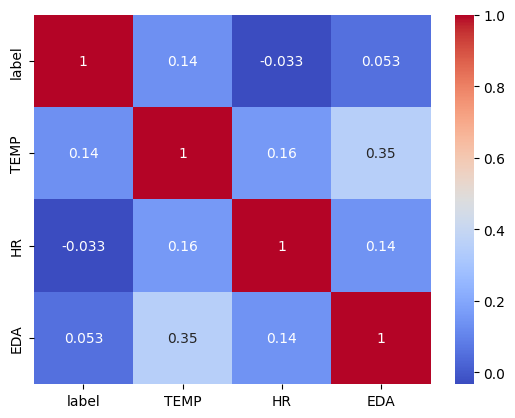

          label      TEMP        HR       EDA
label  1.000000  0.135259 -0.032983  0.053214
TEMP   0.135259  1.000000  0.158172  0.352888
HR    -0.032983  0.158172  1.000000  0.142542
EDA    0.053214  0.352888  0.142542  1.000000


In [ ]:
# Calculate the correlation coefficients between the variables TEMP, HR, EDA with id and label
corr_matrix = merged_df[["id", "label", "TEMP", "HR", "EDA"]].corr()

# Plot the correlation matrix as a heatmap
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Display the plot
plt.show()

print(corr_matrix)


In [31]:
if abs(corr_temp) >= 0.2:
    print("There is a moderate correlation between temperature and stress level.")
elif abs(corr_temp) >= 0.1:
    print("There is a weak correlation between temperature and stress level.")
else:
    print("There is no correlation between temperature and stress level.")
    
if abs(corr_hr) >= 0.2:
    print("There is a moderate correlation between HR and stress level.")
elif abs(corr_hr) >= 0.1:
    print("There is a weak correlation between HR and stress level.")
else:
    print("There is no correlation between HR and stress level.")
    
if abs(corr_eda) >= 0.2:
    print("There is a moderate correlation between EDA and stress level.")
elif abs(corr_eda) >= 0.1:
    print("There is a weak correlation between EDA and stress level.")
else:
    print("There is no correlation between EDA and stress level.")

There is a weak correlation between temperature and stress level.
There is no correlation between HR and stress level.
There is no correlation between EDA and stress level.


In [ ]:
import pandas as pd

# Group data by stress level and calculate summary statistics for maximum temperature, HR, and EDA
temp_summary = merged_df.groupby("label")["TEMP"].max().describe()
hr_summary = merged_df.groupby("label")["HR"].max().describe()
eda_summary = merged_df.groupby("label")["EDA"].max().describe()

# Create a dataframe with the summary statistics
summary_df = pd.DataFrame({
    "Low Stress": [temp_summary["min"], hr_summary["min"], eda_summary["min"]],
    "Medium Stress": [temp_summary["50%"], hr_summary["50%"], eda_summary["50%"]],
    "High Stress": [temp_summary["max"], hr_summary["max"], eda_summary["max"]]
}, index=["Max Temperature", "Max HR", "Max EDA"])

# Print the summary table
print(summary_df)


                 Low Stress  Medium Stress  High Stress
Max Temperature   35.910000      36.570000    36.590000
Max HR           163.500000     169.930000   180.230000
Max EDA           24.167313      43.563389    59.760712


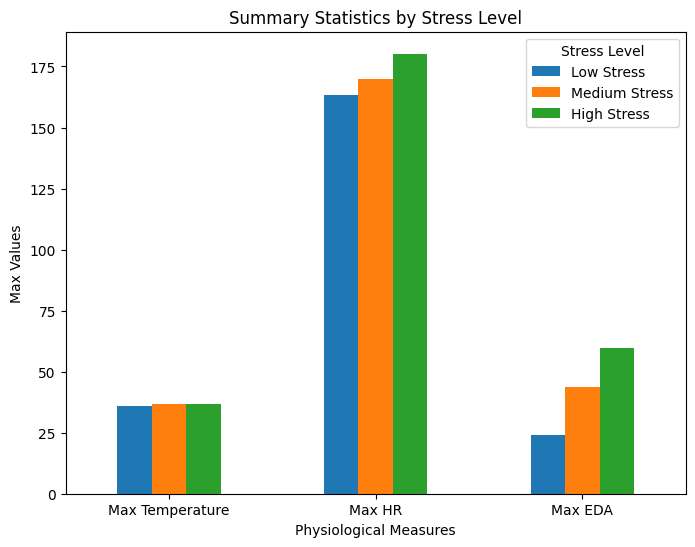

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by stress level and calculate summary statistics for maximum temperature, HR, and EDA
temp_summary = merged_df.groupby("label")["TEMP"].max().describe()
hr_summary = merged_df.groupby("label")["HR"].max().describe()
eda_summary = merged_df.groupby("label")["EDA"].max().describe()

# Create a dataframe with the summary statistics
summary_df = pd.DataFrame({
    "Low Stress": [temp_summary["min"], hr_summary["min"], eda_summary["min"]],
    "Medium Stress": [temp_summary["50%"], hr_summary["50%"], eda_summary["50%"]],
    "High Stress": [temp_summary["max"], hr_summary["max"], eda_summary["max"]]
}, index=["Max Temperature", "Max HR", "Max EDA"])

# Plot the summary table as a bar plot
ax = summary_df.plot(kind="bar", figsize=(8, 6), rot=0)

# Set plot attributes
ax.set_xlabel("Physiological Measures")
ax.set_ylabel("Max Values")
ax.set_title("Summary Statistics by Stress Level")
ax.legend(title="Stress Level")

# Save plot as an image
plt.savefig("summary_table.png", dpi=300, bbox_inches="tight")


*Machine Learning Model*

**Random Forest Classifier**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error

X = merged_df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']] # input variables
y = merged_df['label'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier on the training data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

# Evaluate the model performance using R-squared and RMSE metrics
print('R-squared score for id prediction:', r2_score(y_test, y_pred))
print('RMSE for id prediction:', mean_squared_error(y_test, y_pred, squared=False))



Accuracy: 0.9963975159854638
Precision: 0.9964019327235848
Recall: 0.9963975159854638
F1-score: 0.9963911329310874
R-squared score for id prediction: 0.9848809478748556
RMSE for id prediction: 0.09767551236480584


Confusion Matrix: [[ 209436    2876  150814]
 [   7433   76945   77075]
 [  41971   20687 1313396]]
Classification Report:               precision    recall  f1-score   support

           0       0.81      0.58      0.67    363126
           1       0.77      0.48      0.59    161453
           2       0.85      0.95      0.90   1376054

    accuracy                           0.84   1900633
   macro avg       0.81      0.67      0.72   1900633
weighted avg       0.84      0.84      0.83   1900633

59395/59395 [==============================] - 87s 1ms/step
ROC AUC Score: 0.8915304205918291


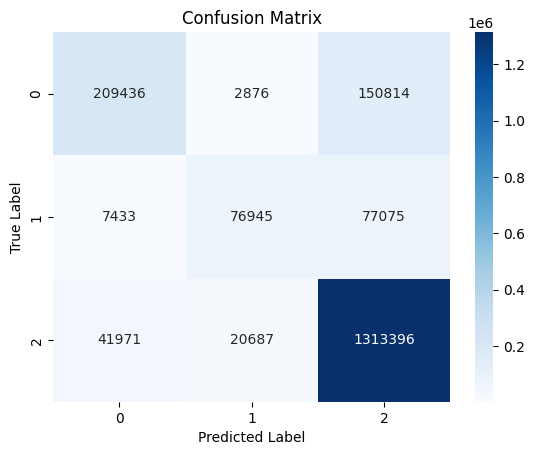

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
print('Classification Report:', classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, model.predict(X_test), multi_class='ovr', average='weighted'))

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


**Decision Tree Classifier**

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error

X = merged_df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']] # input variables
y = merged_df['label'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)


clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

# Calculate precision
prec = precision_score(y_test, y_pred, average='weighted')

# Calculate recall
rec = recall_score(y_test, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

# Evaluate the model performance using R-squared and RMSE metrics
print('R-squared score for id prediction:', r2_score(y_test, y_pred))
print('RMSE for id prediction:', mean_squared_error(y_test, y_pred, squared=False))

importances = clf.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")


Accuracy: 98.12%
Precision: 0.981
Recall: 0.981
F1 Score: 0.981
R-squared score for id prediction: 0.9157150516266738
RMSE for id prediction: 0.22907991998898194
X: 0.07442826376620058
Y: 0.10348342566354757
Z: 0.084922575966992
TEMP: 0.24233588603530073
HR: 0.15724967725346647
EDA: 0.33758017131449264


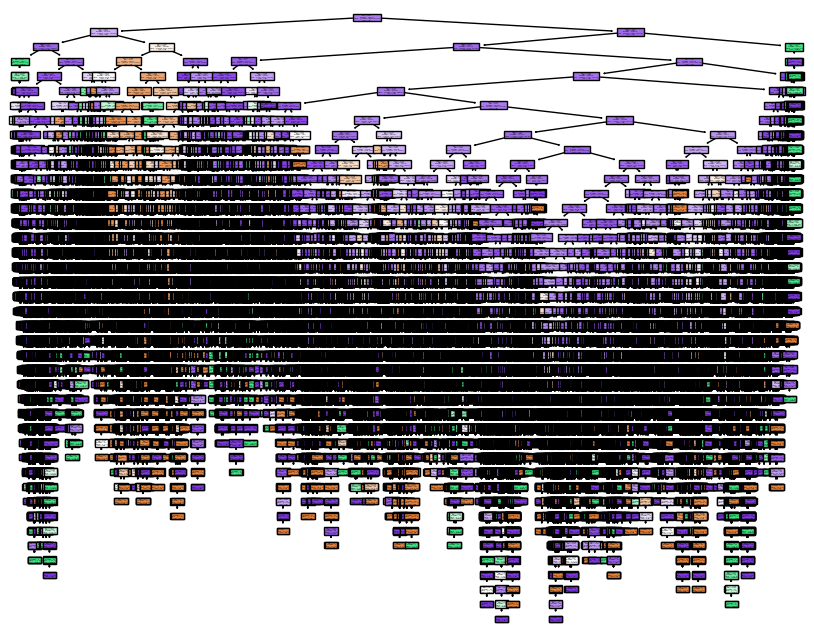

In [72]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 8))
plot_tree(clf, filled=True, feature_names=['TEMP', 'HR', 'EDA'], class_names=['low', 'medium', 'high'])
plt.show()


**Logistic Regression**

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X = merged_df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']] # input variables
y = merged_df['label'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model with increased max_iter and different solver
clf = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
clf.fit(X_train_scaled, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate the model performance using accuracy score, precision score, recall score, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Evaluate the model performance using R-squared and RMSE metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the results
print("Accuracy:", accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('R-squared score for id prediction:', r2)
print('RMSE for id prediction:', rmse)


Accuracy: 0.7240582479626524
Precision: 0.7040330697548992
Recall: 0.7240582479626524
F1-score: 0.6083421608468513
R-squared score for id prediction: -0.3453121516993394
RMSE for id prediction: 0.9213718689699535


Confusion Matrix: 
[[    205       0  362921]
 [    118       0  161335]
 [     90       0 1375964]]


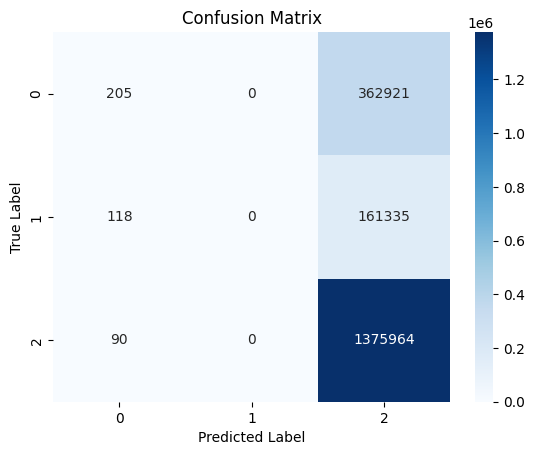

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.50      0.00      0.00    363126
         1.0       1.00      0.00      0.00    161453
         2.0       0.72      1.00      0.84   1376054

    accuracy                           0.72   1900633
   macro avg       0.74      0.33      0.28   1900633
weighted avg       0.70      0.72      0.61   1900633



In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(cm)

import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
cr = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report: ")
print(cr)

**k-Nearest Neighbors (kNN)**

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error

X = merged_df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']] # input variables
y = merged_df['label'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

# Evaluate the model performance using R-squared and RMSE metrics
print('R-squared score for id prediction:', r2_score(y_test, y_pred))
print('RMSE for id prediction:', mean_squared_error(y_test, y_pred, squared=False))


Accuracy: 0.8877801273432488
Precision: 0.884444164765427
Recall: 0.8877801273432488
F1-score: 0.8850319971058334
R-squared score for id prediction: 0.45681936515657173
RMSE for id prediction: 0.5815422010848164


              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77   1512867
         1.0       0.79      0.65      0.71    564199
         2.0       0.91      0.95      0.93   5979270

    accuracy                           0.89   8056336
   macro avg       0.84      0.78      0.80   8056336
weighted avg       0.88      0.89      0.89   8056336



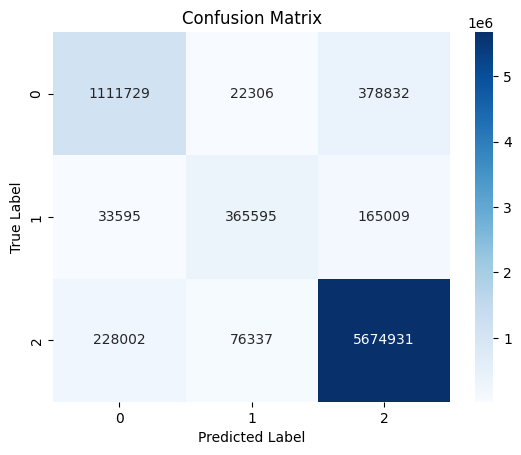

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Naive Bayes Classifier**

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error

X = merged_df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']] # input variables
y = merged_df['label'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

# Evaluate the model performance using R-squared and RMSE metrics
print('R-squared score for id prediction:', r2_score(y_test, y_pred))
print('RMSE for id prediction:', mean_squared_error(y_test, y_pred, squared=False))


Accuracy: 0.7377208448108421
Precision: 0.6575130973879407
Recall: 0.7377208448108421
F1-score: 0.6417415649296843
R-squared score for id prediction: -0.3511235091410174
RMSE for id prediction: 0.9171843211210675


              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77   1512867
         1.0       0.79      0.65      0.71    564199
         2.0       0.91      0.95      0.93   5979270

    accuracy                           0.89   8056336
   macro avg       0.84      0.78      0.80   8056336
weighted avg       0.88      0.89      0.89   8056336



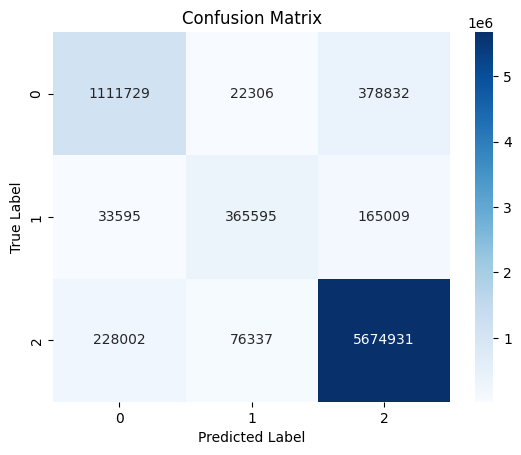

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Neural Networks**

In [10]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
import numpy as np

# Split data into training and testing sets
X = merged_df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']].values # input variables
y = merged_df['label'].values # target variable
y = to_categorical(y) # one-hot encoding of target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=6))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_test = np.argmax(y_test, axis=-1)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

# Evaluate the model performance using R-squared and RMSE metrics
print('R-squared score for id prediction:', r2_score(y_test, y_pred))
print('RMSE for id prediction:', mean_squared_error(y_test, y_pred, squared=False))


Epoch 1/10
237580/237580 [==============================] - 569s 2ms/step - loss: 0.5784 - accuracy: 0.7838
Epoch 2/10
237580/237580 [==============================] - 913s 4ms/step - loss: 0.5217 - accuracy: 0.8075
Epoch 3/10
237580/237580 [==============================] - 434s 2ms/step - loss: 0.5041 - accuracy: 0.8145
Epoch 4/10
237580/237580 [==============================] - 439s 2ms/step - loss: 0.4911 - accuracy: 0.8191
Epoch 5/10
237580/237580 [==============================] - 500s 2ms/step - loss: 0.4739 - accuracy: 0.8245
Epoch 6/10
237580/237580 [==============================] - 420s 2ms/step - loss: 0.4596 - accuracy: 0.8293
Epoch 7/10
237580/237580 [==============================] - 455s 2ms/step - loss: 0.4481 - accuracy: 0.8334
Epoch 8/10
237580/237580 [==============================] - 864s 4ms/step - loss: 0.4397 - accuracy: 0.8369
Epoch 9/10
237580/237580 [==============================] - 562s 2ms/step - loss: 0.4340 - accuracy: 0.8392
Epoch 10/10
59395/59395 [===

              precision    recall  f1-score   support

           0       0.81      0.58      0.67    363126
           1       0.77      0.48      0.59    161453
           2       0.85      0.95      0.90   1376054

    accuracy                           0.84   1900633
   macro avg       0.81      0.67      0.72   1900633
weighted avg       0.84      0.84      0.83   1900633



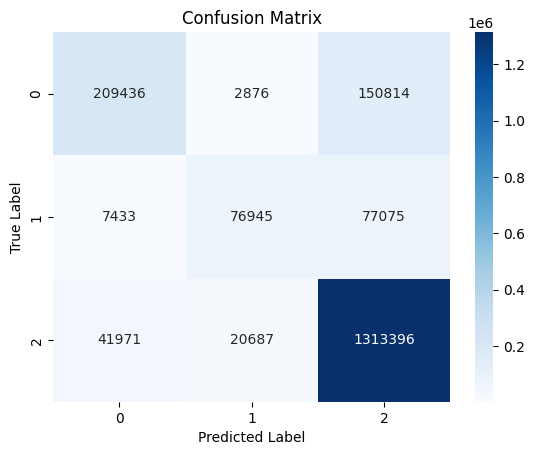

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Result:

Six machine learning models were trained on a dataset containing six physiological variables to predict different levels of stress. The Random Forest Classifier achieved high accuracy (99.64%) and good performance on precision, recall, and F1-score. The Logistic Regression model showed poor performance with a negative R-squared score. The KNN Classifier model outperformed the logistic regression model. The Neural Network achieved an accuracy of 0.84 on the test set.

EDA was found to be the most important variable, followed by HR, Z, and X, in detecting stress. The study recommends that the company should address the class imbalance in the dataset, assess the relevance of physiological signals in detecting stress accurately, optimize for recall, and ensure that the algorithm's decision-making process is transparent and explainable to end-users.